In [1]:
import pandas as pd;
import pickle
import numpy as np;
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

% matplotlib inline

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
def evaluateBucketsVsPrevious(bucketIn, changeCutoff = False):
    tol = 0
    if changeCutoff:
        tol = cutoff_tol
    bucketDF = pd.DataFrame({'newPugoAmount' : bucketIn, 'Bucket' : range(len(bucketIn))})
    temp = x_scaled.copy()
    temp[['PuGoOffer', 'GrantSchol', 'Tuition', 'Bucket']] = df[['PuGoOffer', 'GrantSchol', 'Tuition', 'Bucket']]
    temp = temp.merge(bucketDF, on = 'Bucket', how = 'left')
    
    temp['IsEnrolledOrMatriculated'] = df.IsEnrolled
    temp['PredictionScore'] = predict_model.predict_proba(temp[cols])[:, 1]
    temp['OldPredictions'] = temp['PredictionScore'] >= cutoff_threshold - tol
    temp['TuitionAfterGrantsOld'] = temp.tuition_after_grants
    temp['tuition_after_grants'] = temp['Tuition'] - temp['newPugoAmount'] - temp['GrantSchol']
    temp['tuition_after_grants'] = deconstruct(temp['tuition_after_grants'], 'tuition_after_grants')
    temp['NewPredictionScore'] = predict_model.predict_proba(temp[cols])[:, 1]
    temp['NewPredictions'] = temp['NewPredictionScore'] >= cutoff_threshold - tol
    
    old_student_counts = temp['OldPredictions'].sum()
    new_student_counts = temp['NewPredictions'].sum()
    old_pugo_offer = temp['PuGoOffer'].sum()
    new_pugo_offer = temp['newPugoAmount'].sum()
    old_pugo_used = (temp['PuGoOffer'] * temp['OldPredictions']).sum()
    new_pugo_used = (temp['newPugoAmount'] * temp['NewPredictions']).sum()
    
    return old_student_counts, old_pugo_offer, old_pugo_used, new_student_counts, new_pugo_offer, new_pugo_used

In [3]:
df = pd.read_csv('../predictions/forOpt/data_all.csv')
df[['PuGoOffer', 'GrantSchol', 'Tuition', 'ApplYr', 'IsAdmitted']] = pd.read_csv('../predictions/forOpt/pugoTuitionAndGrants.csv')

In [4]:
band_location = 'bestInds/20.pkl'
creator.create('FitnessMulti', base.Fitness, weights=(0.99, 0.01))
creator.create('Individual', list, fitness=creator.FitnessMulti)

with open(band_location, 'rb') as band_input:
    best = pickle.load(band_input)
    
number_of_buckets = len(best)

In [5]:
with open('changingFundAmounts/evals.pkl', 'rb') as file_input:
    evals = pickle.load(file_input)

In [6]:
yearsToUse = [2015, 2016, 2017]
df = df[df.ApplYr.isin(yearsToUse)]
df = df[df.IsAdmitted == 1]

In [7]:
df.groupby('ApplYr').PuGoOffer.sum()

ApplYr
2015    34415500
2016    30564500
2017    30913750
Name: PuGoOffer, dtype: int64

In [8]:
df.ApplYr.value_counts()

2017    9683
2016    9054
2015    8795
Name: ApplYr, dtype: int64

In [9]:
data_all = pd.DataFrame()
for each in yearsToUse:
    current = df[df.ApplYr == each]
    current = current.sort_values(['AcademicScore_imputed', 'HolisticAcademicScore', 'HighSchoolGPA', 'TestScore', 'AcademicRankPctYr'], ascending = False)
    current['BucketRank'] = np.arange(len(current))[::-1]
    current['Bucket'] = pd.cut(current['BucketRank'], number_of_buckets, labels = False)
    data_all = data_all.append(current)

In [10]:
data_all2 = data_all.copy()

In [11]:
bucketDF = pd.DataFrame({'newPugoAmount' : best, 'Bucket' : range(len(best))})
data_all2 = data_all2.merge(bucketDF, on = 'Bucket', how = 'left')

In [12]:
data_all2.loc[data_all2.ApplYr == 2017, 'PuGoOffer'] = data_all2['newPugoAmount']
data_all2.loc[data_all2.ApplYr == 2017, 'ApplYr'] = 'optimized'

In [13]:
data_all2 = data_all2.append(current)

In [14]:
data_all2[data_all2.ApplYr == 2017].groupby('Bucket')['PuGoOffer'].mean()

Bucket
0      584.020619
1     1384.814050
2     2017.561983
3     2332.644628
4     2555.268595
5     2754.132231
6     2975.206612
7     3241.735537
8     3208.161157
9     3325.257732
10    3490.185950
11    3480.888430
12    3550.103306
13    3664.256198
14    3833.677686
15    3978.822314
16    4020.144628
17    4191.632231
18    4460.743802
19    4804.123711
Name: PuGoOffer, dtype: float64

In [15]:
data_all['OfferedPuGo'] = data_all.PuGoOffer > 0
data_all2['OfferedPuGo'] = data_all2.PuGoOffer > 0

In [16]:
enrollRates = data_all.groupby(['ApplYr', 'OfferedPuGo', 'IsEnrolled'])['TestScore'].count().unstack()
enrollRates['Total'] = data_all.groupby(['ApplYr', 'OfferedPuGo'])['TestScore'].count()
enrollRates.columns = ['NotEnrolled', 'Enrolled', 'Total']
enrollRates['NotEnrolledPct'] = enrollRates['NotEnrolled'] / enrollRates['Total'] * 100
enrollRates['EnrolledPct'] = enrollRates['Enrolled'] / enrollRates['Total'] * 100
enrollRates = enrollRates.reset_index()
enrollRates

ApplYr  OfferedPuGo  NotEnrolled  Enrolled  Total  NotEnrolledPct  \
0    2015        False         2299       690   2989       76.915356   
1    2015         True         5065       741   5806       87.237341   
2    2016        False         3949       732   4681       84.362316   
3    2016         True         3936       437   4373       90.006860   
4    2017        False         1242       348   1590       78.113208   
5    2017         True         7191       902   8093       88.854566   

   EnrolledPct  
0    23.084644  
1    12.762659  
2    15.637684  
3     9.993140  
4    21.886792  
5    11.145434

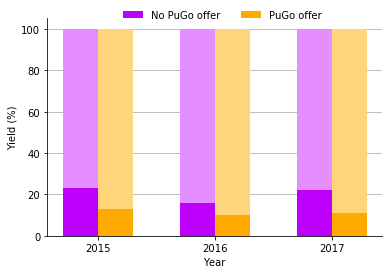

In [17]:
w = 0.3
years = np.array(yearsToUse)
plt.figure()
ax = plt.subplot(111)
plt.bar(years, [100] * len(yearsToUse), width = w, color = '#e48eff', zorder = 20)
plt.bar(years + w, [100] * len(yearsToUse), width = w, color = '#ffd57c', zorder = 20)
plt.bar(years, enrollRates[~enrollRates.OfferedPuGo].EnrolledPct, width = w, color = '#bd00fc', zorder = 20, label = 'No PuGo offer')
plt.bar(years + w, enrollRates[enrollRates.OfferedPuGo].EnrolledPct, width = w, color = '#ffaa00', zorder = 20, label = 'PuGo offer')
plt.xticks(years + w / 2, [str(int(x)) for x in years])
plt.xlabel('Year')
plt.ylabel('Yield (%)')
#plt.title('PuGo Annual Yields')
plt.legend(bbox_to_anchor = (0.2,0.95), ncol = 2, frameon = False)
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("yieldsOld.png", bbox_inches='tight')

In [18]:
enrollRates = data_all2.groupby(['ApplYr', 'OfferedPuGo', 'IsEnrolled'])['TestScore'].count().unstack()
enrollRates['Total'] = data_all2.groupby(['ApplYr', 'OfferedPuGo'])['TestScore'].count()
enrollRates.columns = ['NotEnrolled', 'Enrolled', 'Total']
enrollRates['NotEnrolledPct'] = enrollRates['NotEnrolled'] / enrollRates['Total'] * 100
enrollRates['EnrolledPct'] = enrollRates['Enrolled'] / enrollRates['Total'] * 100
enrollRates = enrollRates.reset_index()
enrollRates

ApplYr  OfferedPuGo  NotEnrolled  Enrolled  Total  NotEnrolledPct  \
0       2015        False         2299       690   2989       76.915356   
1       2015         True         5065       741   5806       87.237341   
2       2016        False         3949       732   4681       84.362316   
3       2016         True         3936       437   4373       90.006860   
4       2017        False         1242       348   1590       78.113208   
5       2017         True         7191       902   8093       88.854566   
6  optimized        False          720       249    969       74.303406   
7  optimized         True         7713      1001   8714       88.512738   

   EnrolledPct  
0    23.084644  
1    12.762659  
2    15.637684  
3     9.993140  
4    21.886792  
5    11.145434  
6    25.696594  
7    11.487262

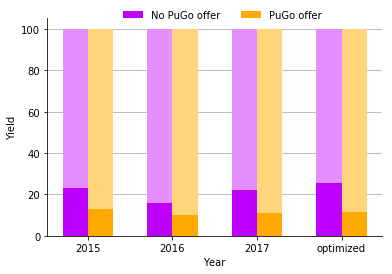

In [19]:
w = 0.3
years = np.array(yearsToUse + [2018])
plt.figure()
ax = plt.subplot(111)
plt.bar(years, [100] * len(years), width = w, color = '#e48eff', zorder = 20)
plt.bar(years + w, [100] * len(years), width = w, color = '#ffd57c', zorder = 20)
plt.bar(years, enrollRates[~enrollRates.OfferedPuGo].EnrolledPct, width = w, color = '#bd00fc', zorder = 20, label = 'No PuGo offer')
plt.bar(years + w, enrollRates[enrollRates.OfferedPuGo].EnrolledPct, width = w, color = '#ffaa00', zorder = 20, label = 'PuGo offer')
plt.xticks(years + w / 2, [str(int(x)) for x in years[:-1]] + ['optimized'])

plt.xlabel('Year')
plt.ylabel('Yield')
#plt.title('PuGo Annual Yields')
plt.legend(bbox_to_anchor = (0.2,0.95), ncol = 2, frameon = False)
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig("yieldsNew.png", bbox_inches='tight')

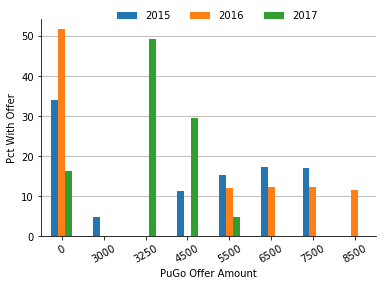

In [20]:
temp = (data_all.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30, color = ['#2476b3', '#ff7e16', '#309f30'])
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 3, bbox_to_anchor = (0.2,0.95))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersOld.png", bbox_inches='tight')

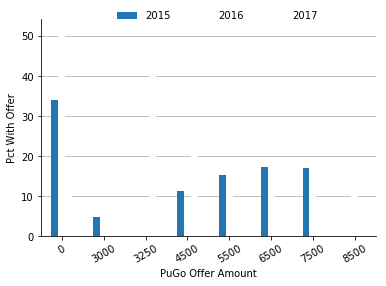

In [21]:
temp = (data_all.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30, color = ['#2476b3', '#ffffff', '#ffffff'])
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 3, bbox_to_anchor = (0.2,0.95))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersOldBlue.png", bbox_inches='tight')

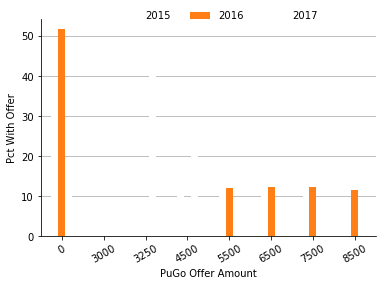

In [22]:
temp = (data_all.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30, color = ['#ffffff', '#ff7e16', '#ffffff'])
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 3, bbox_to_anchor = (0.2,0.95))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersOldOrange.png", bbox_inches='tight')

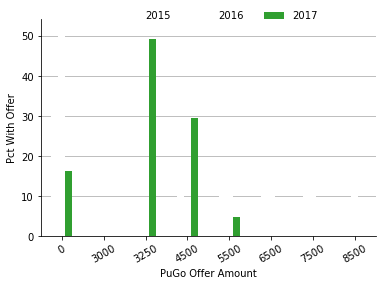

In [23]:
temp = (data_all.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30, color = ['#ffffff', '#ffffff', '#309f30'])
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 3, bbox_to_anchor = (0.2,0.95))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersOldGreen.png", bbox_inches='tight')

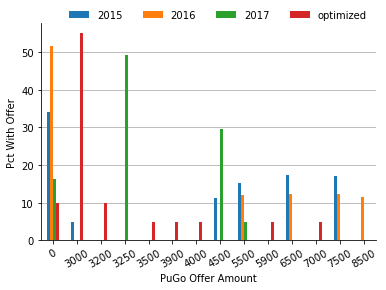

In [24]:
temp = (data_all2.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all2.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30)
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 4, bbox_to_anchor = (1,1.1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersNew.png", bbox_inches='tight')

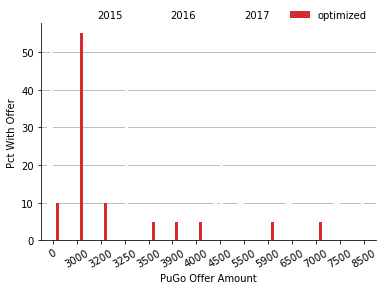

In [25]:
temp = (data_all2.groupby('ApplYr')['PuGoOffer'].value_counts() / data_all2.groupby('ApplYr')['PuGoOffer'].count()).unstack().fillna(0) * 100
ax = temp.T.plot(kind = 'bar', zorder = 20, rot = 30, color = ['#ffffff', '#ffffff', '#ffffff', '#d52b2c'])
ax.yaxis.grid()
ax.set_xlabel("PuGo Offer Amount")
ax.set_ylabel("Pct With Offer")
ax.legend(frameon = False, ncol = 4, bbox_to_anchor = (1,1.1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("offersNewRed.png", bbox_inches='tight')

In [26]:
testScores = data_all.groupby(['ApplYr', 'OfferedPuGo', 'IsEnrolled'])['TestScore'].mean().unstack()
testScores.columns = ['NotEnrolled', 'Enrolled']
testScores = testScores.reset_index()
testScores

ApplYr  OfferedPuGo  NotEnrolled     Enrolled
0    2015        False  1283.080035  1257.982609
1    2015         True  1401.125765  1368.002699
2    2016        False  1334.987845  1302.049180
3    2016         True  1449.637195  1429.109840
4    2017        False  1313.129630  1245.557471
5    2017         True  1411.850508  1375.478936

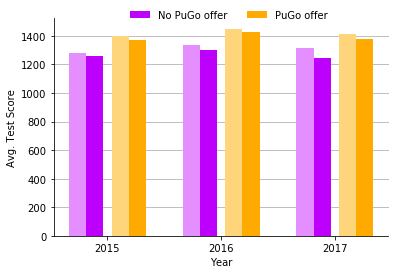

In [27]:
w = 0.15
years = np.array(yearsToUse)
plt.figure()
ax = plt.subplot(111)
plt.bar(years, testScores[~testScores.OfferedPuGo].NotEnrolled, width = w, color = '#e48eff', zorder = 20)
plt.bar(years + w, testScores[~testScores.OfferedPuGo].Enrolled, width = w, color = '#bd00fc', zorder = 20, label = 'No PuGo offer')
plt.bar(years + 2*w + 0.5*w, testScores[testScores.OfferedPuGo].NotEnrolled, width = w, color = '#ffd57c', zorder = 20)
plt.bar(years + 3*w + 0.5*w, testScores[testScores.OfferedPuGo].Enrolled, width = w, color = '#ffaa00', zorder = 20, label = 'PuGo offer')
plt.xticks(years + 2*w - 0.25*w, [str(int(x)) for x in years])
plt.xlabel('Year')
plt.ylabel('Avg. Test Score')
#plt.title('PuGo Annual Yields')
plt.legend(bbox_to_anchor = (0.2,0.95), ncol = 2, frameon = False)
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("profileOld.png", bbox_inches='tight')

In [28]:
testScores = data_all2.groupby(['ApplYr', 'OfferedPuGo', 'IsEnrolled'])['TestScore'].mean().unstack()
testScores.columns = ['NotEnrolled', 'Enrolled']
testScores = testScores.reset_index()
testScores

ApplYr  OfferedPuGo  NotEnrolled     Enrolled
0       2015        False  1283.080035  1257.982609
1       2015         True  1401.125765  1368.002699
2       2016        False  1334.987845  1302.049180
3       2016         True  1449.637195  1429.109840
4       2017        False  1313.129630  1245.557471
5       2017         True  1411.850508  1375.478936
6  optimized        False  1359.655556  1266.016064
7  optimized         True  1400.826138  1357.540460

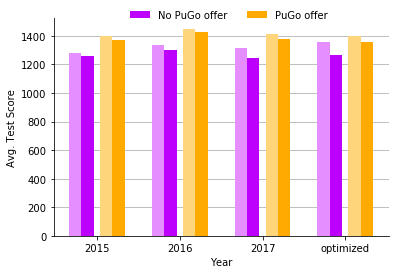

In [29]:
w = 0.15
years = np.array(yearsToUse + [2018])
plt.figure()
ax = plt.subplot(111)
plt.bar(years, testScores[~testScores.OfferedPuGo].NotEnrolled, width = w, color = '#e48eff', zorder = 20)
plt.bar(years + w, testScores[~testScores.OfferedPuGo].Enrolled, width = w, color = '#bd00fc', zorder = 20, label = 'No PuGo offer')
plt.bar(years + 2*w + 0.5*w, testScores[testScores.OfferedPuGo].NotEnrolled, width = w, color = '#ffd57c', zorder = 20)
plt.bar(years + 3*w + 0.5*w, testScores[testScores.OfferedPuGo].Enrolled, width = w, color = '#ffaa00', zorder = 20, label = 'PuGo offer')
plt.xticks(years + 2*w - 0.25*w, [str(int(x)) for x in years[:-1]] + ['optimized'])
plt.xlabel('Year')
plt.ylabel('Avg. Test Score')
#plt.title('PuGo Annual Yields')
plt.legend(bbox_to_anchor = (0.2,0.95), ncol = 2, frameon = False)
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("profileNew.png", bbox_inches='tight')

In [30]:
offeredPuGo = data_all[data_all.OfferedPuGo]
offerEnrolls = offeredPuGo.groupby(['ApplYr', 'PuGoOffer', 'IsEnrolled'])['TestScore'].count().unstack()
offerEnrolls['Total'] = offeredPuGo.groupby(['ApplYr', 'PuGoOffer'])['TestScore'].count()
offerEnrolls.columns = ['NotEnrolled', 'Enrolled', 'Total']
offerEnrolls['NotEnrolledPct'] = offerEnrolls['NotEnrolled'] / offerEnrolls['Total'] * 100
offerEnrolls['EnrolledPct'] = offerEnrolls['Enrolled'] / offerEnrolls['Total'] * 100
offerEnrolls

NotEnrolled  Enrolled  Total  NotEnrolledPct  EnrolledPct
ApplYr PuGoOffer                                                           
2015   3000               350        79    429       81.585082    18.414918
       4500               818       171    989       82.709808    17.290192
       5500              1153       197   1350       85.407407    14.592593
       6500              1356       176   1532       88.511749    11.488251
       7500              1388       118   1506       92.164675     7.835325
2016   5500               966       122   1088       88.786765    11.213235
       6500               977       132   1109       88.097385    11.902615
       7500              1019       105   1124       90.658363     9.341637
       8500               974        78   1052       92.585551     7.414449
2017   3250              4117       658   4775       86.219895    13.780105
       4500              2640       214   2854       92.501752     7.498248
       5500               434        30    464       93.534483     6.465517

In [31]:
data_all[data_all.ApplYr == 2015].groupby(['PuGoOffer'])['TestScore'].count()

PuGoOffer
0       2989
3000     429
4500     989
5500    1350
6500    1532
7500    1506
Name: TestScore, dtype: int64

In [32]:
students = np.array([x[3] for x in evals[1:-1]])
students = students - np.min(students)
fundingSpent = np.array([x[5] for x in evals[1:-1]])
fundingSpent = fundingSpent / 1000000
fundingSpent = fundingSpent.round(3)

students = students[students != 216]
students = students[students != 269]

fundingSpent = fundingSpent[fundingSpent != 2.997]
fundingSpent = fundingSpent[fundingSpent != 3.749]

print students
print fundingSpent

[  0  15  71 132 182 217 238 263 290 316 283 329]
[ 1.925  2.035  2.448  2.698  2.99   3.235  3.488  3.727  3.978  4.202
  4.492  4.749]


In [33]:
evals

[(967, 30851250L, 2317000L, 1087, 29936000L, 3036400L),
 (967, 30851250L, 2317000L, 896, 19220000L, 1925400L),
 (967, 30851250L, 2317000L, 911, 22134000L, 2035300L),
 (967, 30851250L, 2317000L, 967, 23779000L, 2447500L),
 (967, 30851250L, 2317000L, 1028, 27069000L, 2697600L),
 (967, 30851250L, 2317000L, 1078, 29560000L, 2989900L),
 (967, 30851250L, 2317000L, 1113, 30923000L, 3235100L),
 (967, 30851250L, 2317000L, 1134, 34071800L, 3488400L),
 (967, 30851250L, 2317000L, 1159, 36045300L, 3727100L),
 (967, 30851250L, 2317000L, 1186, 38018800L, 3978000L),
 (967, 30851250L, 2317000L, 1212, 40415400L, 4202300L),
 (967, 30851250L, 2317000L, 1179, 42765200.0, 4492400.0),
 (967, 30851250L, 2317000L, 1225, 45161800.0, 4748800.0),
 (967, 30851250L, 2317000L, 1225, 45161400.0, 4995600.0)]

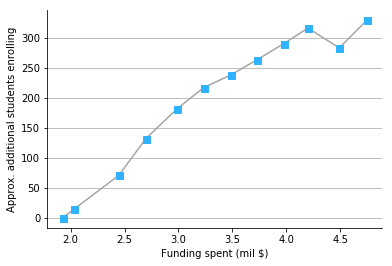

In [34]:
plt.figure()
ax = plt.subplot(111)
plt.plot(fundingSpent, students, marker = 's', mfc = '#30b3ff', mec = '#30b3ff', markersize = 7, c = '#a5a5a5')#ffffff')
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Approx. additional students enrolling')
plt.xlabel('Funding spent (mil $)')
plt.savefig("studentsByFunding.png", bbox_inches='tight')

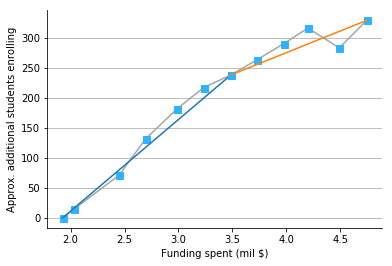

In [35]:
plt.figure()
ax = plt.subplot(111)
plt.plot(fundingSpent[:7], students[:7], marker = 's', mfc = '#30b3ff', mec = '#30b3ff', markersize = 7, c = '#a5a5a5')#ffffff')
plt.plot((fundingSpent[0], fundingSpent[6]), (students[0], students[6]))
plt.plot(fundingSpent[6:], students[6:], marker = 's', mfc = '#30b3ff', mec = '#30b3ff', markersize = 7, c = '#a5a5a5')#ffffff')
plt.plot((fundingSpent[6], fundingSpent[-1]), (students[6], students[-1]))
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Approx. additional students enrolling')
plt.xlabel('Funding spent (mil $)')